# Hello hello,
Welcome to the JQ Model Aquarium, the (future)? home of many models whose intelligence is comparable to the average goldfish

USING ADAM LR_DECAY = 0.9 EVERY 100 EP

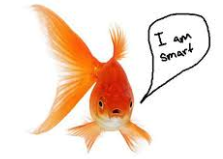

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import csv
import gc
import torchnet as tnt
from tqdm import tqdm_notebook # for-loop progress bar in notebook

# plt setup and the gpu setup
plt.ion()
use_gpu = torch.cuda.is_available()

In [2]:
print(use_gpu) #hallelujah

True


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize(256),
        transforms.RandomResizedCrop(224), #apparently get an error if dont have this line
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),    
        transforms.Grayscale(),    
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
    
    'testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        
    ]),
}

data_dir = '/home/jquach12/jq_shenanigans/data/blackAndWhite_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation','testing']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation','testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation','testing']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

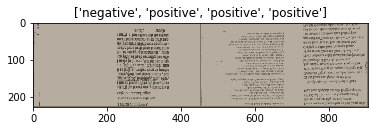

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [5]:
# ========================================
# Step 4. define the training process.
#
# TODO: The basic process of train and validation is defined. Please implement the overall average validation 
# confusion matrix, meaning for each validation (after running all epochs), get the confusion matrix for that book,
# repeat this for the rest of 10 books. THen get the overall performance. Also, implement the early-stop as you
# originally has in your code. :) I removed them here for clarity. You can add them back. 
# ========================================



trainLosses = []
valLosses = []
def train(model, criterion, optimizer, data_loaders, num_epochs=25, early_stopping = None):

    # stop the training, validation, and test loop
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        # looping parameters
        running_loss = 0.0
        
        
        confusion_matrix = tnt.meter.ConfusionMeter(2)
        
        # loop through train and val phase in each epoch
        for phase in ['train', 'validation']:
            # check train or val
            if phase == 'train':                
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            # Iterate over each book
            running_loss = 0.0
            
         
            confusion_matrix = tnt.meter.ConfusionMeter(2)
            for book in tqdm_notebook(data_loaders[phase]):
                for data in data_loaders[phase][book]:
                    # get the inputs;  wrap them in Variable and make them into gpu or not
                    inputs, labels = data # input size: [5, 1, 28, 28] ; keep the dummy color channel:1
                    if use_gpu:
                        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)
                    
                    # back
                    if phase == 'train': 
                        loss.backward()
                        optimizer.step()

                    # Add to confusion matrix
                    confusion_matrix.add(outputs.data, labels.data)

                    # statistics
                   
                    running_loss += loss.item()
                    
            
            # report evaluation
            print('Phase:%s' %phase)
            print('Confusion matrix:\n', confusion_matrix.conf)
            if phase == 'train':
                print('train loss', running_loss)
                trainLosses.append(running_loss)
               
            else:
                print('validation loss', running_loss)
                valLosses.append(running_loss)
               
            
        
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
def plotLosses(trainLosses,valLosses,title = ""):
    plt.title(title)
    plt.plot(trainLosses,label = "training")
    plt.plot(valLosses,label = "validation")
    #plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
    plt.xlabel("Epochs")
    plt.ylabel("Error")
    plt.legend()
    plt.show()

#plotLosses(trainLosses,valLosses,"JQ_MODEL")

In [8]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#from https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=3, padding = 1).cuda()
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3, padding = 1).cuda()
        self.conv3 = nn.Conv2d(20, 40, kernel_size=3, padding = 1).cuda()
        self.conv2_drop = nn.Dropout2d(p = 0.2)
        self.conv3_drop = nn.Dropout2d(p = 0.1)
      
        #assumes a batch size of 50
        self.fc1 = nn.Linear(31360,64).cuda()
        self.fc2 = nn.Linear(64, 25).cuda()
        self.fc3 = nn.Linear(25,2).cuda()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(x)), 2))
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        
        
        x = x.view(x.size(0),-1) #clutch line
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        #return x

In [9]:
trainLosses = []
valLosses = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    
    for epoch in range(num_epochs):
        cm_posAndNeg = tnt.meter.ConfusionMeter(2)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                if phase == 'validation':
                    cm_posAndNeg.add(outputs.data, labels.data)
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                trainLosses.append(epoch_loss)
            elif phase == 'validation':
                valLosses.append(epoch_loss)
                
            if phase == 'validation':
                print('Confusion matrix:\n', cm_posAndNeg.conf)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model #got really high acc when if phase == 'val' i.e. this never happens
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
net1 = Net1()

In [11]:


criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(net1.parameters(), lr=0.001, momentum = 0.9) #set lr a little high to decay later

# Decay LR by a factor of 0.9 every 100 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

In [12]:
num_epochs = 500
net1 = train_model(net1, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 1/500
----------
train Loss: 0.6907 Acc: 0.5379
Confusion matrix:
 [[  0 168]
 [  0 168]]
validation Loss: 0.6900 Acc: 0.5000

Epoch 2/500
----------
train Loss: 0.6892 Acc: 0.5332
Confusion matrix:
 [[122  46]
 [ 99  69]]
validation Loss: 0.6872 Acc: 0.5685

Epoch 3/500
----------
train Loss: 0.6864 Acc: 0.5581
Confusion matrix:
 [[ 45 123]
 [  6 162]]
validation Loss: 0.6836 Acc: 0.6161

Epoch 4/500
----------
train Loss: 0.6804 Acc: 0.5782
Confusion matrix:
 [[ 24 144]
 [  3 165]]
validation Loss: 0.6774 Acc: 0.5625

Epoch 5/500
----------
train Loss: 0.6799 Acc: 0.5829
Confusion matrix:
 [[102  66]
 [ 16 152]]
validation Loss: 0.6727 Acc: 0.7560

Epoch 6/500
----------
train Loss: 0.6728 Acc: 0.5699
Confusion matrix:
 [[157  11]
 [111  57]]
validation Loss: 0.6621 Acc: 0.6369

Epoch 7/500
----------
train Loss: 0.6581 Acc: 0.6173
Confusion matrix:
 [[134  34]
 [  8 160]]
validation Loss: 0.6426 Acc: 0.8750

Epoch 8/500
----------
train Loss: 0.6651 Acc: 0.5948
Confusion matri

Confusion matrix:
 [[122  46]
 [  3 165]]
validation Loss: 0.4392 Acc: 0.8542

Epoch 63/500
----------
train Loss: 0.4752 Acc: 0.7820
Confusion matrix:
 [[131  37]
 [  8 160]]
validation Loss: 0.4333 Acc: 0.8661

Epoch 64/500
----------
train Loss: 0.4513 Acc: 0.7962
Confusion matrix:
 [[131  37]
 [  5 163]]
validation Loss: 0.4129 Acc: 0.8750

Epoch 65/500
----------
train Loss: 0.4736 Acc: 0.7915
Confusion matrix:
 [[128  40]
 [  3 165]]
validation Loss: 0.4257 Acc: 0.8720

Epoch 66/500
----------
train Loss: 0.4680 Acc: 0.7962
Confusion matrix:
 [[130  38]
 [  3 165]]
validation Loss: 0.3950 Acc: 0.8780

Epoch 67/500
----------
train Loss: 0.4687 Acc: 0.7832
Confusion matrix:
 [[134  34]
 [ 25 143]]
validation Loss: 0.4722 Acc: 0.8244

Epoch 68/500
----------
train Loss: 0.4620 Acc: 0.7974
Confusion matrix:
 [[136  32]
 [  7 161]]
validation Loss: 0.4216 Acc: 0.8839

Epoch 69/500
----------
train Loss: 0.4675 Acc: 0.7915
Confusion matrix:
 [[128  40]
 [  3 165]]
validation Loss: 0.4

Confusion matrix:
 [[137  31]
 [ 88  80]]
validation Loss: 0.5713 Acc: 0.6458

Epoch 124/500
----------
train Loss: 0.4068 Acc: 0.8329
Confusion matrix:
 [[129  39]
 [ 23 145]]
validation Loss: 0.4678 Acc: 0.8155

Epoch 125/500
----------
train Loss: 0.4169 Acc: 0.8199
Confusion matrix:
 [[127  41]
 [ 34 134]]
validation Loss: 0.5648 Acc: 0.7768

Epoch 126/500
----------
train Loss: 0.4615 Acc: 0.7950
Confusion matrix:
 [[139  29]
 [ 35 133]]
validation Loss: 0.4685 Acc: 0.8095

Epoch 127/500
----------
train Loss: 0.4188 Acc: 0.8021
Confusion matrix:
 [[133  35]
 [ 11 157]]
validation Loss: 0.4630 Acc: 0.8631

Epoch 128/500
----------
train Loss: 0.4121 Acc: 0.8187
Confusion matrix:
 [[138  30]
 [ 20 148]]
validation Loss: 0.4339 Acc: 0.8512

Epoch 129/500
----------
train Loss: 0.4540 Acc: 0.8021
Confusion matrix:
 [[129  39]
 [  6 162]]
validation Loss: 0.4255 Acc: 0.8661

Epoch 130/500
----------
train Loss: 0.4445 Acc: 0.7938
Confusion matrix:
 [[127  41]
 [ 13 155]]
validation Lo

train Loss: 0.3980 Acc: 0.8258
Confusion matrix:
 [[145  23]
 [ 17 151]]
validation Loss: 0.3866 Acc: 0.8810

Epoch 185/500
----------
train Loss: 0.3935 Acc: 0.8294
Confusion matrix:
 [[121  47]
 [  8 160]]
validation Loss: 0.4405 Acc: 0.8363

Epoch 186/500
----------
train Loss: 0.3981 Acc: 0.8164
Confusion matrix:
 [[134  34]
 [  9 159]]
validation Loss: 0.4066 Acc: 0.8720

Epoch 187/500
----------
train Loss: 0.4005 Acc: 0.8199
Confusion matrix:
 [[140  28]
 [ 71  97]]
validation Loss: 0.5340 Acc: 0.7054

Epoch 188/500
----------
train Loss: 0.4136 Acc: 0.8318
Confusion matrix:
 [[133  35]
 [  7 161]]
validation Loss: 0.4286 Acc: 0.8750

Epoch 189/500
----------
train Loss: 0.4010 Acc: 0.8104
Confusion matrix:
 [[135  33]
 [ 11 157]]
validation Loss: 0.4221 Acc: 0.8690

Epoch 190/500
----------
train Loss: 0.3928 Acc: 0.8187
Confusion matrix:
 [[133  35]
 [  4 164]]
validation Loss: 0.3850 Acc: 0.8839

Epoch 191/500
----------
train Loss: 0.4216 Acc: 0.8187
Confusion matrix:
 [[138

train Loss: 0.3690 Acc: 0.8353
Confusion matrix:
 [[139  29]
 [ 50 118]]
validation Loss: 0.4703 Acc: 0.7649

Epoch 246/500
----------
train Loss: 0.3969 Acc: 0.8270
Confusion matrix:
 [[139  29]
 [ 36 132]]
validation Loss: 0.4622 Acc: 0.8065

Epoch 247/500
----------
train Loss: 0.3973 Acc: 0.8306
Confusion matrix:
 [[132  36]
 [  6 162]]
validation Loss: 0.3959 Acc: 0.8750

Epoch 248/500
----------
train Loss: 0.3786 Acc: 0.8246
Confusion matrix:
 [[130  38]
 [  4 164]]
validation Loss: 0.3914 Acc: 0.8750

Epoch 249/500
----------
train Loss: 0.3744 Acc: 0.8294
Confusion matrix:
 [[132  36]
 [ 40 128]]
validation Loss: 0.5051 Acc: 0.7738

Epoch 250/500
----------
train Loss: 0.3832 Acc: 0.8341
Confusion matrix:
 [[132  36]
 [ 12 156]]
validation Loss: 0.4241 Acc: 0.8571

Epoch 251/500
----------
train Loss: 0.3559 Acc: 0.8483
Confusion matrix:
 [[131  37]
 [  9 159]]
validation Loss: 0.3857 Acc: 0.8631

Epoch 252/500
----------
train Loss: 0.3538 Acc: 0.8472
Confusion matrix:
 [[135

train Loss: 0.3594 Acc: 0.8329
Confusion matrix:
 [[132  36]
 [ 52 116]]
validation Loss: 0.5083 Acc: 0.7381

Epoch 307/500
----------
train Loss: 0.3784 Acc: 0.8294
Confusion matrix:
 [[132  36]
 [ 16 152]]
validation Loss: 0.4526 Acc: 0.8452

Epoch 308/500
----------
train Loss: 0.3527 Acc: 0.8555
Confusion matrix:
 [[138  30]
 [ 16 152]]
validation Loss: 0.3513 Acc: 0.8631

Epoch 309/500
----------
train Loss: 0.3450 Acc: 0.8519
Confusion matrix:
 [[140  28]
 [ 23 145]]
validation Loss: 0.3587 Acc: 0.8482

Epoch 310/500
----------
train Loss: 0.3509 Acc: 0.8460
Confusion matrix:
 [[141  27]
 [ 14 154]]
validation Loss: 0.3663 Acc: 0.8780

Epoch 311/500
----------
train Loss: 0.3588 Acc: 0.8329
Confusion matrix:
 [[140  28]
 [ 31 137]]
validation Loss: 0.4079 Acc: 0.8244

Epoch 312/500
----------
train Loss: 0.3607 Acc: 0.8507
Confusion matrix:
 [[110  58]
 [ 29 139]]
validation Loss: 0.5645 Acc: 0.7411

Epoch 313/500
----------
train Loss: 0.3983 Acc: 0.8081
Confusion matrix:
 [[119

train Loss: 0.3280 Acc: 0.8507
Confusion matrix:
 [[130  38]
 [ 30 138]]
validation Loss: 0.4676 Acc: 0.7976

Epoch 368/500
----------
train Loss: 0.3409 Acc: 0.8531
Confusion matrix:
 [[143  25]
 [ 55 113]]
validation Loss: 0.4522 Acc: 0.7619

Epoch 369/500
----------
train Loss: 0.3503 Acc: 0.8436
Confusion matrix:
 [[138  30]
 [ 57 111]]
validation Loss: 0.4768 Acc: 0.7411

Epoch 370/500
----------
train Loss: 0.3688 Acc: 0.8377
Confusion matrix:
 [[137  31]
 [ 14 154]]
validation Loss: 0.3474 Acc: 0.8661

Epoch 371/500
----------
train Loss: 0.3303 Acc: 0.8472
Confusion matrix:
 [[144  24]
 [ 31 137]]
validation Loss: 0.3846 Acc: 0.8363

Epoch 372/500
----------
train Loss: 0.3465 Acc: 0.8472
Confusion matrix:
 [[141  27]
 [105  63]]
validation Loss: 0.5547 Acc: 0.6071

Epoch 373/500
----------
train Loss: 0.3487 Acc: 0.8460
Confusion matrix:
 [[131  37]
 [ 56 112]]
validation Loss: 0.5387 Acc: 0.7232

Epoch 374/500
----------
train Loss: 0.3474 Acc: 0.8472
Confusion matrix:
 [[135

train Loss: 0.3459 Acc: 0.8566
Confusion matrix:
 [[138  30]
 [ 44 124]]
validation Loss: 0.4310 Acc: 0.7798

Epoch 429/500
----------
train Loss: 0.3335 Acc: 0.8614
Confusion matrix:
 [[140  28]
 [ 61 107]]
validation Loss: 0.4670 Acc: 0.7351

Epoch 430/500
----------
train Loss: 0.3249 Acc: 0.8590
Confusion matrix:
 [[138  30]
 [ 23 145]]
validation Loss: 0.3768 Acc: 0.8423

Epoch 431/500
----------
train Loss: 0.3222 Acc: 0.8495
Confusion matrix:
 [[144  24]
 [ 30 138]]
validation Loss: 0.3948 Acc: 0.8393

Epoch 432/500
----------
train Loss: 0.3178 Acc: 0.8472
Confusion matrix:
 [[138  30]
 [ 17 151]]
validation Loss: 0.3413 Acc: 0.8601

Epoch 433/500
----------
train Loss: 0.3728 Acc: 0.8282
Confusion matrix:
 [[141  27]
 [ 30 138]]
validation Loss: 0.3738 Acc: 0.8304

Epoch 434/500
----------
train Loss: 0.3173 Acc: 0.8709
Confusion matrix:
 [[141  27]
 [ 21 147]]
validation Loss: 0.3780 Acc: 0.8571

Epoch 435/500
----------
train Loss: 0.3541 Acc: 0.8412
Confusion matrix:
 [[122

train Loss: 0.3482 Acc: 0.8507
Confusion matrix:
 [[134  34]
 [ 21 147]]
validation Loss: 0.3747 Acc: 0.8363

Epoch 490/500
----------
train Loss: 0.3389 Acc: 0.8555
Confusion matrix:
 [[139  29]
 [ 43 125]]
validation Loss: 0.4030 Acc: 0.7857

Epoch 491/500
----------
train Loss: 0.3217 Acc: 0.8649
Confusion matrix:
 [[140  28]
 [ 38 130]]
validation Loss: 0.4068 Acc: 0.8036

Epoch 492/500
----------
train Loss: 0.3003 Acc: 0.8614
Confusion matrix:
 [[134  34]
 [  8 160]]
validation Loss: 0.3343 Acc: 0.8750

Epoch 493/500
----------
train Loss: 0.3447 Acc: 0.8519
Confusion matrix:
 [[142  26]
 [ 45 123]]
validation Loss: 0.3982 Acc: 0.7887

Epoch 494/500
----------
train Loss: 0.2991 Acc: 0.8720
Confusion matrix:
 [[137  31]
 [ 60 108]]
validation Loss: 0.4699 Acc: 0.7292

Epoch 495/500
----------
train Loss: 0.3357 Acc: 0.8483
Confusion matrix:
 [[142  26]
 [ 45 123]]
validation Loss: 0.4729 Acc: 0.7887

Epoch 496/500
----------
train Loss: 0.3182 Acc: 0.8460
Confusion matrix:
 [[126

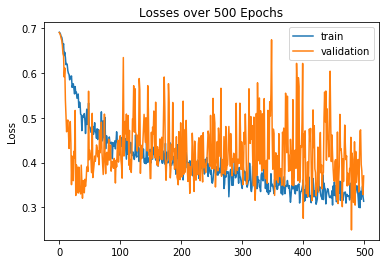

In [19]:
plt.plot(trainLosses,label = "train")
plt.plot(valLosses,label = "validation")
plt.title("Losses over " + str(num_epochs) +  " Epochs")
plt.ylabel('Loss')
plt.legend()
plt.show()

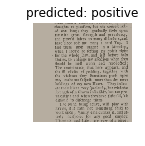

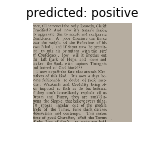

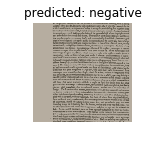

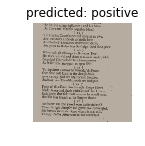

In [20]:
visualize_model(net1,4)

plt.ioff()
plt.show()

In [21]:
torch.save(net1.state_dict(), '/home/jquach12/net1_weight500ep.pt')
torch.save(net1, '/home/jquach12/net1_model500ep.pt')

RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/csrc/generic/serialization.cpp:17